**RUN THIS CODE IN KAGGLE KERNEL**

**IMPORTING ALL NECESSARY LIBRARIES**

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from PIL import Image

import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
from torchvision import transforms
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, classification_report, accuracy_score
from torch.utils.data import random_split
import csv

**CHECKED FOR GPU**

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


**The driver_imgs_list.csv contains a list of training images, their subject id and class label id**

In [3]:
#Reading the driver_imgs_list.csv
data = pd.read_csv("../input/state-farm-distracted-driver-detection/driver_imgs_list.csv")
data.head()

,subject,classname,img
0,p012,c0,img_10206.jpg
1,p012,c0,img_27079.jpg
2,p012,c0,img_50749.jpg
3,p012,c0,img_97089.jpg
4,p012,c0,img_37741.jpg


In [4]:
#To find the count of all unique values in subject
data['subject'].value_counts()

p021    2474
p022    2466
p024    2452
p026    2392
p066    2068
p049    2022
p051    1840
p015    1750
p035    1696
p047    1670
p012    1646
p064    1640
p075    1628
p056    1588
p050    1580
p052    1480
p045    1448
p041    1210
p042    1182
p072     692
Name: subject, dtype: int64

**LOAD THE DATASET AND DIVIDE INTO TEST AND TRAIN SET**

In [5]:
data.shape

(34924, 3)

In [6]:
#Applying image transformation
transform = transforms.Compose([
    transforms.Resize(256), #Resize the input image to the given size
    transforms.CenterCrop(224), #Crops the given image at the center
    transforms.ToTensor(), #Converts the image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #Normalize a tensor image with mean and standard deviation
])

In [7]:
#Loading the data
dataset = torchvision.datasets.ImageFolder(root='../input/state-farm-distracted-driver-detection/imgs/train', transform=transform)

In [8]:
#Applying train and test split
train, test = random_split(dataset, [15696, 1766])

In [9]:
#To combine a dataset and a sampler, and provide an iterable over the given dataset.
batch_size = 32
trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)

In [10]:
#To create an object which can be iterated one element at a time
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape) #input image shape
print(labels.shape) #label shape

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [11]:
#classes is a list of labels for all 10 classes.
classes = ['safe driving', 'texting - right', 'talking on the phone - right', 'texting - left', 'talking on the phone - left', 'operating the radio', 'drinking', 'reaching behind', 'hair and makeup', 'talking to passenger']

**BUILT THE EVALUATION AND TRAINING FUNCTION TO BE FURTHER USED BY THE MODELS**

In [12]:
#evaluation function used to calculate accuracy of a model.
def evaluation(dataloader, model):
    total, correct = 0, 0
    model.eval()
    for data in dataloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1) #Returns the maximum value of all elements
        total += labels.size(0) #Total images
        correct += (pred == labels).sum().item() #Number of correctly predicted images
    return 100 * correct / total # accuracy

In [13]:
#train function to train a particular model. Here we have set maximum number of epochs as 8.
def train(model):
    loss_epoch_arr = []
    max_epochs = 8
    min_loss = 1000
    for epoch in range(max_epochs):
        for i, data in enumerate(trainloader, 0):
            inputs,labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            opt.zero_grad() #clears old gradients from the last step
            model.train()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward() #computes the derivative of the loss w.r.t. the parameters using backpropagation
            opt.step() #causes the optimizer to take a step based on the gradients of the parameters
            if min_loss > loss.item():
                min_loss = loss.item()
                best_model = copy.deepcopy(model.state_dict()) #creates a deep copy
                print('Min loss %0.2f' % min_loss)
            
            del inputs, labels, outputs
            torch.cuda.empty_cache() #Releases all unoccupied cached memory currently held by the caching allocator
        loss_epoch_arr.append(loss.item())
        model.eval()
        print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, model), evaluation(trainloader, model)))
    plt.plot(loss_epoch_arr)
    plt.show()

**FIRST MODEL IS BUILT USING TRANSFER LEARNING. A RESNET MODEL IS LOADED AND SOME EXTRA LAYERS ARE ADDED TO THE END. NAMED THIS AS 'model1'**

In [14]:
#Downloaded resnet model
model1 = torchvision.models.resnet50(pretrained=True, progress=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [15]:
#Loaded pretrained model and set the parameters as no training required
for p in model1.parameters():
    p.requires_grad = False

In [16]:
#Adding some layers in model1
model1.fc = nn.Sequential(nn.Linear(2048, 1024), #Applies a linear transformation to the incoming data
                           nn.ReLU(), #Applies the rectified linear unit function element-wise
                           nn.Linear(1024, 512),
                           nn.ReLU(),                       
                           nn.Linear(512, 10),
)

In [17]:
#The layer added needs training 
for param in model1.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([1024, 2048])
torch.Size([1024])
torch.Size([512, 1024])
torch.Size([512])
torch.Size([10, 512])
torch.Size([10])


Min loss 2.30
Min loss 2.28
Min loss 2.27
Min loss 2.27
Min loss 2.23
Min loss 2.21
Min loss 2.20
Min loss 2.17
Min loss 2.16
Min loss 2.11
Min loss 2.11
Min loss 2.08
Min loss 2.07
Min loss 1.96
Min loss 1.87
Min loss 1.82
Min loss 1.65
Min loss 1.60
Min loss 1.57
Min loss 1.55
Min loss 1.40
Min loss 1.25
Min loss 1.24
Min loss 1.15
Min loss 1.13
Min loss 1.13
Min loss 0.98
Min loss 0.92
Min loss 0.86
Min loss 0.80
Min loss 0.75
Min loss 0.67
Min loss 0.63
Min loss 0.63
Min loss 0.57
Min loss 0.47
Min loss 0.35
Min loss 0.34
Min loss 0.29
Min loss 0.27
Epoch: 0/8, Test acc: 70.44, Train acc: 72.23
Min loss 0.26
Min loss 0.21
Min loss 0.19
Min loss 0.19
Min loss 0.14
Min loss 0.12
Epoch: 1/8, Test acc: 86.92, Train acc: 88.65
Min loss 0.08
Min loss 0.06
Epoch: 2/8, Test acc: 87.88, Train acc: 89.51
Min loss 0.05
Epoch: 3/8, Test acc: 92.98, Train acc: 93.93
Min loss 0.04
Min loss 0.03
Epoch: 4/8, Test acc: 93.54, Train acc: 95.44
Min loss 0.02
Epoch: 5/8, Test acc: 95.36, Train acc: 96

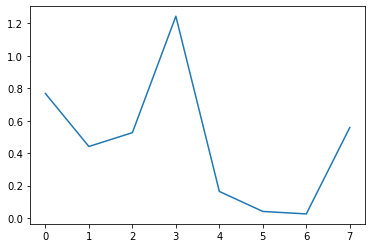

In [18]:
#Trained model1
import torch.optim as optim
learning_rate = 0.001
momentum = 0.9
model1 = model1.to(device)
opt = optim.Adam(model1.parameters(), lr=learning_rate) #Implements Adam algorithm
loss_fn = nn.CrossEntropyLoss() #Combines nn.LogSoftmax() and nn.NLLLoss() in one single class
train(model1)

**BUILT SECOND MODEL WHICH CONTAINS VARIOUS CONVOLUTIONAL LAYERS AND LINEAR LAYERS. NAMED IT AS 'model2'**

In [19]:
# second model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.convblock = nn.Sequential(
            nn.Conv2d(3, 32, 5, stride = (1,1), padding = 2),   #(N,3,224,224)-> (N,32,224,224); Applies a 2D convolution 
            nn.BatchNorm2d(32), #Applies Batch Normalization over a 4D input
            nn.ReLU(), #Applies the rectified linear unit function element-wise
            nn.MaxPool2d(2,2),     #(N,32,224,224)->(N,32,112,112); Applies a 2D max pooling 
            nn.Conv2d(32, 64, 5, stride = (1,1), padding = 2),  #(N,32,112,112)->(N,64,112,112)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2),     #(N,64,112,112)->(N,64,56,56)
            nn.Conv2d(64, 128, 5, stride = (1,1), padding = 2), #(N,64,56,56) ->(N,128,56,56)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2),    #(N,128,56,56)->(N,128,28,28)
            nn.Conv2d(128, 256, 5, stride = (1,1), padding = 2), #(N,128,28,28)->(N,256,28,28)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2,2),  #(N,256,28,28)->(N,256,14,14)
            nn.Conv2d(256, 256, 5, stride = (1,1), padding = 2), #(N,256,14,14)->(N,256,14,14)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2,2)   #(N,256,14,14)->(N,256,7,7)
            
            
        )
        self.denseblock = nn.Sequential(
            nn.Linear(12544, 1024), #Applies a linear transformation to the incoming data
            nn.ReLU(), #Applies the rectified linear unit function element-wise
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Linear(512,10)
        )
        
    def forward(self, x):
        x = self.convblock(x)
        x = x.view(x.size(0),-1) #to get a view of existing tensor
        x = self.denseblock(x)
        return x

Min loss 2.30
Min loss 2.27
Min loss 2.24
Min loss 2.15
Min loss 2.15
Min loss 2.14
Min loss 2.12
Min loss 1.98
Min loss 1.93
Min loss 1.88
Min loss 1.76
Min loss 1.75
Min loss 1.69
Min loss 1.25
Min loss 1.16
Min loss 0.91
Min loss 0.80
Min loss 0.71
Min loss 0.67
Min loss 0.67
Min loss 0.43
Min loss 0.33
Min loss 0.24
Min loss 0.20
Min loss 0.11
Min loss 0.09
Min loss 0.09
Epoch: 0/8, Test acc: 92.07, Train acc: 92.62
Min loss 0.06
Min loss 0.02
Min loss 0.02
Min loss 0.02
Min loss 0.02
Epoch: 1/8, Test acc: 95.41, Train acc: 95.43
Min loss 0.01
Min loss 0.01
Min loss 0.01
Min loss 0.01
Min loss 0.00
Epoch: 2/8, Test acc: 97.06, Train acc: 97.95
Min loss 0.00
Min loss 0.00
Epoch: 3/8, Test acc: 98.02, Train acc: 98.50
Min loss 0.00
Min loss 0.00
Epoch: 4/8, Test acc: 97.28, Train acc: 98.62
Epoch: 5/8, Test acc: 97.90, Train acc: 98.69
Min loss 0.00
Epoch: 6/8, Test acc: 97.57, Train acc: 98.41
Min loss 0.00
Min loss 0.00
Min loss 0.00
Epoch: 7/8, Test acc: 98.87, Train acc: 99.27


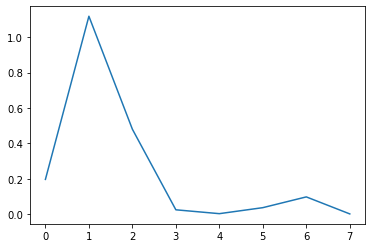

In [20]:
#Trained model2
model2 = Net()
model2 = model2.to(device)
learning_rate = 0.001
momentum = 0.9
model1 = model1.to(device)
opt = optim.Adam(model2.parameters(), lr=learning_rate) #Implements Adam algorithm
loss_fn = nn.CrossEntropyLoss() #Combines nn.LogSoftmax() and nn.NLLLoss() in one single class
train(model2)

**COMPARED THE MODELS BY PERFORMANCE METRICS**

In [21]:
#A function to plot confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.figure(figsize=(20,10))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])): #itertools.product implies Cartesian product of input iterables
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [22]:
#A function used to get PRECISION, RECALL, F1_SCORE, ACCURACY and CONFUSION MATRIX.
def metrics(model):
    y_true = []
    y_pred = []
    for data in testloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        for i in range(len(labels)):
            y_true.append(classes[labels[i]])
        for i in range(len(pred)):
            y_pred.append(classes[pred[i]])
    
    #Printing the first few instances of y_true and y_pred
    for i in range(15):
        print('True Value:',y_true[i],' & ','Predicted Value:',y_pred[i])
        
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    acc = accuracy_score(y_true, y_pred)
    
    print()
    print("Performance metrics of model")
    print()
    print(classification_report(y_true, y_pred))
    print()
    print("Precision is ", round(precision,2))
    print("Recall is ", round(recall,2))
    print("f1 score is ", round(f1,2))
    print("accuracy score is ", round(acc,2))
    cm = confusion_matrix(y_true, y_pred, labels = classes)
    plot_confusion_matrix(cm, classes)

Performance metrics of model made using transfer learning-

True Value: talking to passenger  &  Predicted Value: talking to passenger
True Value: talking to passenger  &  Predicted Value: talking to passenger
True Value: drinking  &  Predicted Value: drinking
True Value: talking on the phone - right  &  Predicted Value: talking on the phone - right
True Value: talking on the phone - left  &  Predicted Value: talking on the phone - left
True Value: talking on the phone - left  &  Predicted Value: talking on the phone - left
True Value: safe driving  &  Predicted Value: safe driving
True Value: talking on the phone - right  &  Predicted Value: talking on the phone - right
True Value: safe driving  &  Predicted Value: safe driving
True Value: operating the radio  &  Predicted Value: operating the radio
True Value: talking on the phone - right  &  Predicted Value: talking on the phone - right
True Value: safe driving  &  Predicted Value: safe driving
True Value: talking on the phone - lef

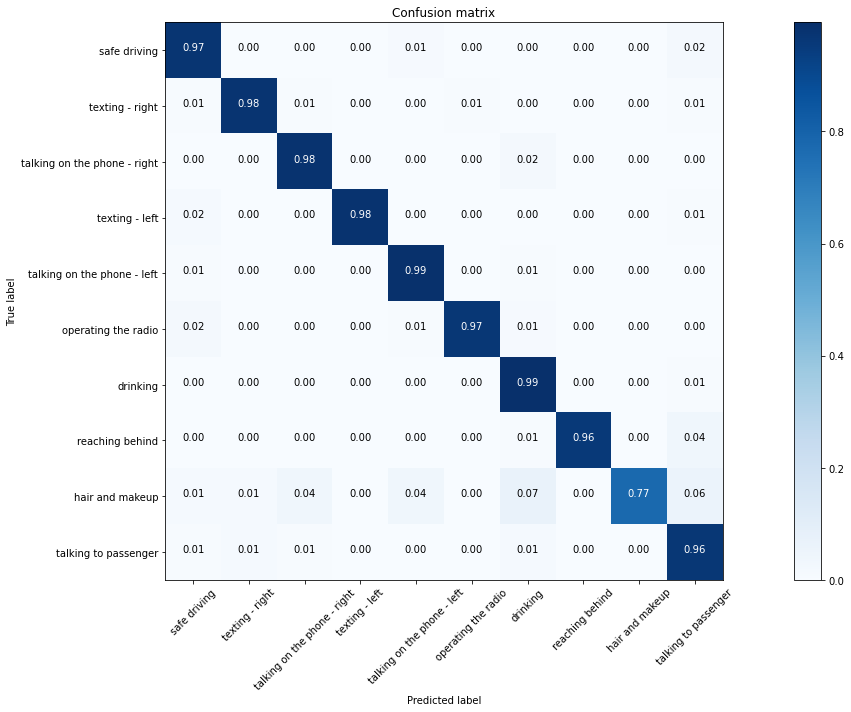

In [23]:
print("Performance metrics of model made using transfer learning-")
print()
metrics(model1)

Performance metrics of self-made model containing various convolutional layers and linear layers-

True Value: hair and makeup  &  Predicted Value: hair and makeup
True Value: operating the radio  &  Predicted Value: operating the radio
True Value: texting - left  &  Predicted Value: texting - left
True Value: texting - right  &  Predicted Value: texting - right
True Value: reaching behind  &  Predicted Value: reaching behind
True Value: safe driving  &  Predicted Value: safe driving
True Value: texting - left  &  Predicted Value: texting - left
True Value: texting - left  &  Predicted Value: texting - left
True Value: operating the radio  &  Predicted Value: operating the radio
True Value: texting - right  &  Predicted Value: texting - right
True Value: hair and makeup  &  Predicted Value: hair and makeup
True Value: talking on the phone - right  &  Predicted Value: talking on the phone - right
True Value: talking to passenger  &  Predicted Value: talking to passenger
True Value: text

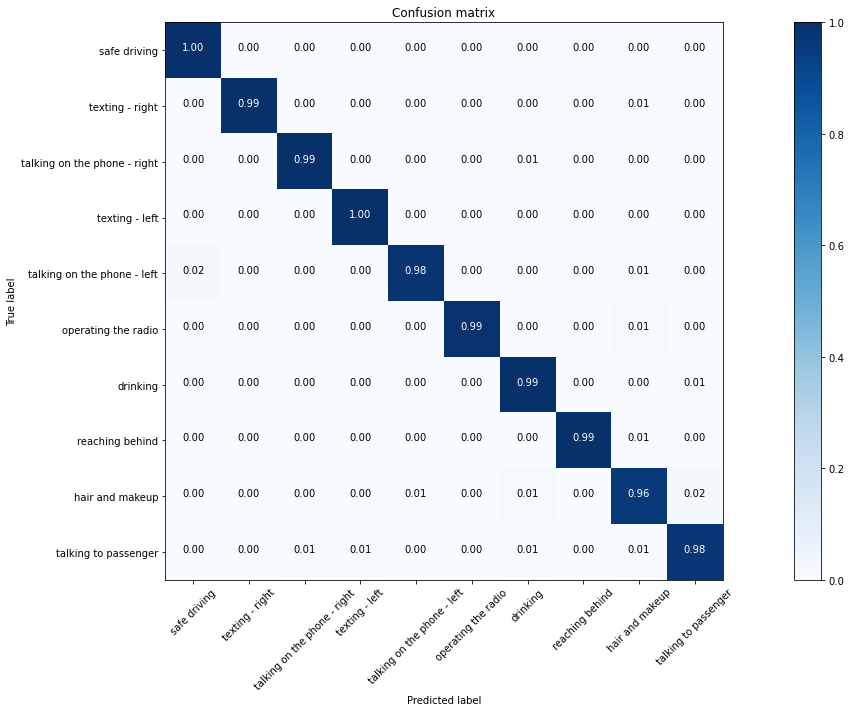

In [24]:
print("Performance metrics of self-made model containing various convolutional layers and linear layers-")
print()
metrics(model2)